In [1]:
import os

os.chdir("..")

In [2]:
%pwd

'/Users/bhargobdeka/Desktop/Projects/RAG-chatbot-Speckly'

In [3]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv()) # important line if cannot load api key

import os
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

# WebSearch tools
os.environ['SERPAPI_API_KEY'] = os.getenv('SERPAPI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['GOOGLE_CSE_ID'] = os.getenv('GOOGLE_CSE_ID')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

# Langsmith Tracing
os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')

In [4]:
import os
import pickle

# Load the saved docs from the local file
with open("crawled_docs/saved_docs.pkl", "rb") as f:
    saved_docs = pickle.load(f)

[Document(page_content=" [![Speckle Docs](/assets/logo-docs.png) Speckle Docs](/)\n\n[User Guide](/)\n\n[Developer Docs](/dev/)\n\n[Automate Guide](/automate/)\n\n[3D Viewer](/viewer/)\n\n[Speckle Website (opens new window)](https://speckle.systems)\n\n[Get Started (opens new window)](https://speckle.systems/getstarted/)\n\n[GitHub (opens new window)](https://github.com/specklesystems/speckle-docs/)\n\n[User Guide](/)\n\n[Developer Docs](/dev/)\n\n[Automate Guide](/automate/)\n\n[3D Viewer](/viewer/)\n\n[Speckle Website (opens new window)](https://speckle.systems)\n\n[Get Started (opens new window)](https://speckle.systems/getstarted/)\n\n[GitHub (opens new window)](https://github.com/specklesystems/speckle-docs/)\n\n*   Developer Docs 👩\u200d💻\n    \n    *   [Introduction](/dev/)\n        *   [Speckle, The Platform](/dev/#speckle-the-platform)\n            \n        *   [Code Repositories](/dev/#code-repositories)\n            \n        *   [Additional tools](/dev/#additional-tools)\n
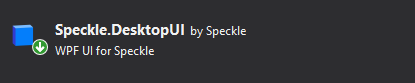
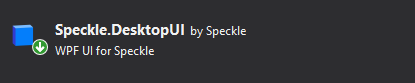

In [5]:
saved_docs

In [25]:
text_list = [doc.page_content for doc in saved_docs]

[" [![Speckle Docs](/assets/logo-docs.png) Speckle Docs](/)\n\n[User Guide](/)\n\n[Developer Docs](/dev/)\n\n[Automate Guide](/automate/)\n\n[3D Viewer](/viewer/)\n\n[Speckle Website (opens new window)](https://speckle.systems)\n\n[Get Started (opens new window)](https://speckle.systems/getstarted/)\n\n[GitHub (opens new window)](https://github.com/specklesystems/speckle-docs/)\n\n[User Guide](/)\n\n[Developer Docs](/dev/)\n\n[Automate Guide](/automate/)\n\n[3D Viewer](/viewer/)\n\n[Speckle Website (opens new window)](https://speckle.systems)\n\n[Get Started (opens new window)](https://speckle.systems/getstarted/)\n\n[GitHub (opens new window)](https://github.com/specklesystems/speckle-docs/)\n\n*   Developer Docs 👩\u200d💻\n    \n    *   [Introduction](/dev/)\n        *   [Speckle, The Platform](/dev/#speckle-the-platform)\n            \n        *   [Code Repositories](/dev/#code-repositories)\n            \n        *   [Additional tools](/dev/#additional-tools)\n            \n        
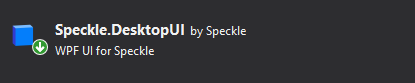
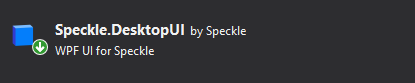

In [26]:
text_list

In [6]:
from utils.vector_store import create_vector_store

store = create_vector_store(saved_docs)

In [7]:
retriever = store.as_retriever()

In [8]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from utils.vector_store import create_vector_store
from utils.grader import GraderUtils
from utils.graph import GraphState
from utils.generate_chain import create_generate_chain
from utils.nodes import GraphNodes
from utils.edges import EdgeGraph
from langgraph.graph import END, StateGraph
from fastapi import FastAPI
from langserve import add_routes

In [9]:
## LLM model
llm = ChatOpenAI(model="gpt-4o", temperature=0)


In [10]:
# Create the generate chain
generate_chain = create_generate_chain(llm)

In [11]:
# test it!
query = "how to install Speckle's python SDK?"
docs = retriever.invoke(query)
generation = generate_chain.invoke({"context": docs, "question": query})
print(generation)

To install Speckle's Python SDK, you can use the `pip` package manager. Here are the steps:

1. Open your terminal or command prompt.
2. Run the following command:

    ```sh
    pip install specklepy
    ```

This will download and install the Speckle Python SDK, which is compatible with Python 3.6 and above.

For more detailed instructions, you can refer to the [SpecklePy repository on GitHub](https://github.com/specklesystems/speckle-py).


In [12]:
# Create an instance of the GraderUtils class
grader = GraderUtils(llm)

# Get the retrieval grader
retrieval_grader = grader.create_retrieval_grader()

# test it!
doc_txt = docs[1].page_content

# check with the grader
print(retrieval_grader.invoke({"question": query,"document": doc_txt}))


{'score': 'yes'}


In [13]:
# Get the hallucination grader
hallucination_grader = grader.create_hallucination_grader()

# test
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [14]:
# Get the code evaluator
code_evaluator = grader.create_code_evaluator()

# test
code_evaluator.invoke({"generation": generation, "question": query, "documents": docs})

{'score': 'yes',
 'feedback': "The generated code correctly and clearly explains how to install Speckle's Python SDK using the pip package manager. It includes the necessary command and mentions the compatibility with Python 3.6 and above. Additionally, it provides a link to the SpecklePy repository for more detailed instructions, which is relevant and helpful."}

In [15]:
# Get the question rewriter
question_rewriter = grader.create_question_rewriter()

question_rewriter.invoke({"question": query})

'What are the steps to install the Speckle Python SDK?'

In [16]:
# Initiating the Graph
workflow = StateGraph(GraphState)

# Create an instance of the GraphNodes class
graph_nodes = GraphNodes(llm, retriever, retrieval_grader, hallucination_grader, code_evaluator, question_rewriter)

# Create an instance of the EdgeGraph class
edge_graph = EdgeGraph(hallucination_grader, code_evaluator)

# Define the nodes
workflow.add_node("retrieve", graph_nodes.retrieve) # retrieve documents
workflow.add_node("grade_documents", graph_nodes.grade_documents)  # grade documents
workflow.add_node("generate", graph_nodes.generate) # generate answers
workflow.add_node("transform_query", graph_nodes.transform_query)  # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    edge_graph.decide_to_generate,
    {
        "transform_query": "transform_query", # "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    edge_graph.grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query", # "transform_query"
    },
)

# Compile
network = workflow.compile()


In [29]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [19]:
inputs = {"question": "How to install speckle's python sdk?"}

response = network.invoke(inputs)

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT IR-RELEVANT---
---GRADE: DOCUMENT IR-RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


In [23]:
print(response['generation'])

To install Speckle's Python SDK, you can use the `pip` package manager. Here are the steps:

1. Open your terminal or command prompt.
2. Run the following command:

    ```bash
    pip install specklepy
    ```

This will download and install the Speckle Python SDK, which is compatible with Python 3.6 and above. 

For more detailed instructions and additional information, you can refer to the [speckle-py repository](https://github.com/specklesystems/speckle-py).
